In [4]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.


In [5]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import importlib

from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

In [6]:
import MyPackage
importlib.reload(MyPackage)
from MyPackage import *

### Creating SQL Database Connection and Converting tables to dfs ###

In [7]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [8]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [9]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [10]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


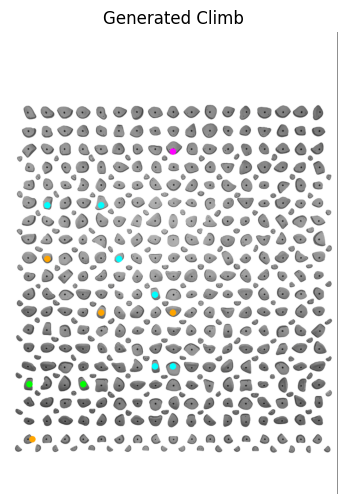

Climb Name: Batman hang


In [11]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)
def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
    else:
        print("The DataFrame is empty.")

# Example usage:
create_random_climb_image(filtered_df) 

### Markov Chain Model

In [12]:
from collections import defaultdict
import string
import random
from collections import defaultdict, Counter
class Markov():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text = self.remove_punctuations(self.get_text())
        self.model = self.model()

    def get_text(self):
        text = []
        for line in open(self.file_path):
            text.append(line)
        return ' '.join(text)
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('','', string.punctuation))
    
    def model(self):
        # split the input text into individual words seperated by spaces
        words = self.text.split(' ')
        markov_dict = defaultdict(list)
        # create list of all word pairs
        for current_word, next_word in zip(words[0:-1], words[1:]):
            markov_dict[current_word].append(next_word)
        markov_dict = dict(markov_dict)
        print('Successfully Trained')
        return markov_dict
    
def predict_words(chain, first_word, number_of_words):
    if first_word in list(chain.keys()):
        word1 = str(first_word)
        predictions = word1.capitalize()
        # Generate the second word from the value list. Set the new word as the first word. Repeat.
        for i in range(number_of_words):
            if word1 not in chain:
                break
            next_words = chain[word1]
            word_counts = Counter(next_words)
            total_count = sum(word_counts.values())
            probabilities = {word: count / total_count for word, count in word_counts.items()}

            # Print the probabilities
            print(f"Current word: {word1}")
            print("Next word probabilities:")
            for word, prob in probabilities.items():
                print(f"  {word}: {prob:.2f}")

            # Choose the next word based on the probabilities
            word2 = random.choices(list(probabilities.keys()), weights=probabilities.values())[0]
            word1 = word2
            predictions += ' ' + word2
        return predictions
    else:
        return "Word not in corpus"
    
def is_valid_sequence(sequence):
    # Count the number of start holds (r12) and finish holds (r14)
    start_hold_count = sequence.count('r12')
    finish_hold_count = sequence.count('r14')

    # Check if the counts are within the specified range
    return 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2

def predict_valid_sequence(chain, start_hold, number_of_words):
    while True:
        # Generate a sequence of words using the Markov chain model
        sequence = predict_words(chain, start_hold, number_of_words)
        
        # Convert the sequence to a string
        sequence_str = ' '.join(sequence.split())
        # Check if the sequence is valid
        if is_valid_sequence(sequence_str):
            return sequence_str

Successfully Trained
Current word: 1081r15
Next word probabilities:
  1080r15: 0.04
  1133r12: 0.01
  1472r15: 0.01
  1144r12: 0.00
  1150r15: 0.00
  1131r15: 0.01
  1096r15: 0.03
  1471r15: 0.02
  1469r15: 0.03
  1476r15: 0.02
  1092r15: 0.00
  1470r15: 0.03
  1490r15: 0.00
  1149r12: 0.06
  1098r15: 0.00
  1076r15: 0.02
  1130r15: 0.01
  1110r15: 0.01
  1079r15: 0.03
  1503r15: 0.00
  1468r15: 0.03
  1078r15: 0.03
  1146r12: 0.01
  1103r15: 0.01
  1138r12: 0.00
  1097r15: 0.02
  1128r12: 0.01
  1148r12: 0.01
  1131r12: 0.01
  1169r12: 0.00
  1099r12: 0.00
  1478r15: 0.01
  1111r15: 0.00
  1475r15: 0.00
  1136r12: 0.01
  1147r12: 0.02
  1489r15: 0.01
  1113r15: 0.02
  1486r15: 0.01
  1133r15: 0.01
  1114r12: 0.01
  1134r12: 0.01
  1129r12: 0.01
  1488r15: 0.01
  1112r12: 0.00
  1166r12: 0.02
  1127r12: 0.01
  1164r12: 0.00
  1153r12: 0.00
  1101r15: 0.00
  1117r12: 0.00
  1116r15: 0.00
  1077r15: 0.02
  1480r15: 0.01
  1106r15: 0.00
  1151r12: 0.00
  1145r12: 0.01
  1094r15: 0.00
  10

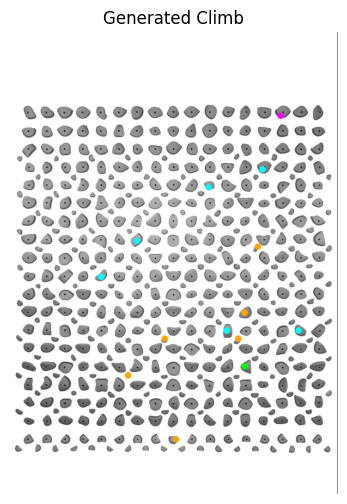

In [13]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1081r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [14]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

In [15]:
print(len(filtered_df))

98951


### Prepare Data into npz file ###

In [16]:
def get_hold_vector(row, col):
    if not isinstance(row, int):
        raise TypeError(f"Row index must be an integer, got {type(row)} row: {row}")
    if not isinstance(col, int):
        raise TypeError(f"Column index must be an integer, got {type(col)} col: {col}")
    
    if row > 34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    if isinstance(climb_angle, torch.Tensor):
        climb_angle_cpu = climb_angle.cpu().numpy()
    else:
        climb_angle_cpu = np.array(climb_angle)
    climb_angle_radians = np.deg2rad(climb_angle_cpu)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341 
    return id

def ids_to_hold_val_class_id(hold_class_id, val_class_id):
    hold_val_class_id = (hold_class_id) * 4 + val_class_id
    return hold_val_class_id

def hold_val_class_id_to_ids(hold_val_class_id):
    val_class_id = hold_val_class_id % 4
    hold_class_id = int((hold_val_class_id - val_class_id) /4)
    return hold_class_id, val_class_id

def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_index2 = id_to_index2(hold_ids[i])
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_index2, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(index2, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = index2_to_id(int(index2))
    hold_class_id = id_to_class_id(hold_id)
    x, y = id_to_coordinate(hold_id)

    val_class_id = val-2
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (y, x, val_class_id, index2, hold_val_class_id, hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.72674690e+01  1.70532955e+01 -3.65590926e-01  2.40509815e+02
  8.99983708e+02 -4.15454791e-03  5.91963003e-01]


### RNN Model ###

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix, climb_matrix[:, 3].astype(int)

class SequenceDataset(Dataset):
    def __init__(self, dataset):
        self.sequences, self.labels = self.extract_sequences(dataset)

    def extract_sequences(self, dataset):
        sequences = []
        labels = []

        for i in range(len(dataset)):
            climb_matrix, class_ids = dataset[i]
            for j in range(1, len(climb_matrix)):
                sequence = climb_matrix[:j]
                label = class_ids[j]
                sequences.append(sequence)
                labels.append(label)

        return sequences, labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = self.labels[idx]
        return sequence, label

class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layer for hold_val_class prediction
        self.fc_hold_val_class = nn.Linear(hidden_size, 476)  # Define the linear layer first
        
        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_hold_val_class.weight)
        init.constant_(self.fc_hold_val_class.bias, 0)
        
        # Apply weight normalization using torch.nn.utils.parametrizations.weight_norm
        self.fc_hold_val_class = weight_norm.weight_norm(self.fc_hold_val_class, name='weight', dim=None)

    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        hold_val_class_pred = self.fc_hold_val_class(out)
        
        return hold_val_class_pred, hn, cn

# Define collate function for DataLoader to handle variable-length sequences
def collate_fn(batch):
    sequences = [seq for seq, _ in batch]
    labels = torch.tensor([label for _, label in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, labels

def custom_loss(pred_class_probabilities, labels, padded_sequences, lengths, top_k=5, coord_weight=1.0):
    batch_size = pred_class_probabilities.size(0)

    # Compute cross-entropy loss
    cross_entropy_loss = F.cross_entropy(pred_class_probabilities, labels)

    # Sort and select top-K predicted class probabilities
    values, top_k_indices = torch.topk(pred_class_probabilities, k=top_k, dim=1)

    # Pre-compute expected hold coordinates for all sequences in the batch
    expected_hold_ids = padded_sequences[torch.arange(batch_size), lengths.cpu().long() - 1, 4].long()
    expected_tuple_values = torch.stack([torch.tensor(id_to_coordinate(class_id_to_id(hold_val_class_id_to_ids(hold_id.item())[0])), dtype=torch.float, device=pred_class_probabilities.device) for hold_id in expected_hold_ids])

    total_coord_loss = torch.zeros(1, device=pred_class_probabilities.device)

    for i in range(batch_size):
        pred_tuple_values_list = [torch.tensor(id_to_coordinate(class_id_to_id(hold_val_class_id_to_ids(pred_class_id.item())[0])), dtype=torch.float, device=pred_class_probabilities.device)
                                  for pred_class_id in top_k_indices[i]]

        pred_tuple_values = torch.stack(pred_tuple_values_list)  # Shape: (top_k, 2)

        # Calculate Huber loss for row and col
        loss_other_values = F.huber_loss(pred_tuple_values, expected_tuple_values[i].expand_as(pred_tuple_values), reduction='sum')

        # Accumulate total loss
        total_coord_loss = total_coord_loss + loss_other_values

    # Average loss over top-K predictions and batch size
    total_coord_loss = total_coord_loss / (top_k * batch_size)

    # Combine losses
    total_loss = cross_entropy_loss + coord_weight * total_coord_loss
    
    return total_loss

def calculate_expected_euclidean_distance(hold_pred_logits, actual_hold_id, id_to_coordinate_func, device):
    """
    Calculate the Expected Euclidean Distance (EED) between predicted hold distributions and actual hold positions.
    
    Args:
        hold_pred_logits (torch.Tensor): Logits for hold_id predictions (batch_size x num_holds).
        actual_hold_id (torch.Tensor): Actual hold_id labels (batch_size).
        id_to_coordinate_func (function): Function to convert hold_id to (x, y) coordinates.
        device (torch.device): Device to perform calculations on.
        
    Returns:
        torch.Tensor: Average EED for the batch.
    """
    batch_size, num_holds = hold_pred_logits.size()
    
    # Step 1: Apply Softmax to get probability distributions
    P_hold = F.softmax(hold_pred_logits, dim=1)  # Shape: (batch_size, num_holds)
    
    # Step 2: Convert all hold_ids to (x, y) coordinates
    # Create a tensor of hold_ids from 0 to num_holds-1
    hold_ids = torch.arange(num_holds, device=device).long()  # Shape: (num_holds)
    
    # Convert hold_ids to coordinates
    with torch.no_grad():
        # Apply the id_to_coordinate function to all hold_ids
        coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_id in hold_ids], device=device, dtype=torch.float32)  # Shape: (num_holds, 2)
    
    # Step 3: Get actual hold coordinates
    actual_coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_id in actual_hold_id], device=device, dtype=torch.float32)  # Shape: (batch_size, 2)
    
    # Step 4: Expand dimensions to compute pairwise differences
    # predicted_coordinates: (1, num_holds, 2)
    predicted_coordinates = coordinates.unsqueeze(0)  # Shape: (1, num_holds, 2)
    
    # actual_coordinates: (batch_size, 1, 2)
    actual_coordinates = actual_coordinates.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    
    # Step 5: Compute Euclidean distances: (batch_size, num_holds)
    distances = torch.norm(predicted_coordinates - actual_coordinates, dim=2)  # Shape: (batch_size, num_holds)
    
    # Step 6: Compute Expected Euclidean Distance
    # Multiply distances by probabilities and sum over holds
    expected_distances = torch.sum(P_hold * distances, dim=1)  # Shape: (batch_size)
    
    # Step 7: Return the average EED across the batch
    return expected_distances.mean()

# Load your dataset
dataset = ClimbDataset('standardized_climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create sequence datasets for train and validation
sequence_train_dataset = SequenceDataset(train_dataset)
sequence_val_dataset = SequenceDataset(val_dataset)
print("Sequence Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(sequence_train_dataset)}")
print(f"Validation Dataset Size: {len(sequence_val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for sequence datasets
train_loader = DataLoader(sequence_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(sequence_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Define loss functions
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for padded_sequences, lengths, labels in train_loader:
        padded_sequences = padded_sequences.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)

        # Compute custom loss
        batch_loss = custom_loss(hold_val_class_pred, labels, padded_sequences, lengths, top_k=5)

        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        correct_train_preds += (torch.argmax(hold_val_class_pred, dim=1) == labels).sum().item()
        total_train_preds += labels.size(0)
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    total_val_eed = 0.0
    with torch.no_grad():
        for padded_sequences, lengths, labels in val_loader:
            padded_sequences = padded_sequences.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
            batch_loss = custom_loss(hold_val_class_pred, labels, padded_sequences, lengths, top_k=5)

            running_val_loss += batch_loss.item()
            correct_val_preds += (torch.argmax(hold_val_class_pred, dim=1) == labels).sum().item()
            total_val_preds += labels.size(0)

            batch_eed = calculate_expected_euclidean_distance(hold_val_class_pred, labels, id_to_coordinate, device)
            total_val_eed += batch_eed.item()
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_eed = total_val_eed / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}",
          f"Average Validation Expected Euclidean Distance (EED): {avg_val_eed:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Train and Val Datasets Created
Sequence Train and Val Datasets Created
Train Dataset Size: 306548
Validation Dataset Size: 87485
Test Dataset Size: 4000
Train and Val Loaders Created


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# After computing predictions and ground truths
y_true = []  # List to hold true labels
y_pred = []  # List to hold predicted labels

model.eval()
with torch.no_grad():
    for padded_sequences, lengths, labels in val_loader:
        padded_sequences = padded_sequences.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)
        
        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
        predictions = torch.argmax(hold_val_class_pred, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 0.0282, Recall: 0.0385, F1 Score: 0.0239


c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ViniciusDugue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Frequencies of each hold class ID (sorted by class ID):
Hold Class ID: 1, Frequency: 1
Hold Class ID: 2, Frequency: 4
Hold Class ID: 3, Frequency: 5
Hold Class ID: 4, Frequency: 7
Hold Class ID: 5, Frequency: 12
Hold Class ID: 6, Frequency: 16
Hold Class ID: 7, Frequency: 10
Hold Class ID: 8, Frequency: 10
Hold Class ID: 9, Frequency: 14
Hold Class ID: 10, Frequency: 15
Hold Class ID: 11, Frequency: 7
Hold Class ID: 12, Frequency: 14
Hold Class ID: 13, Frequency: 9
Hold Class ID: 14, Frequency: 9
Hold Class ID: 15, Frequency: 5
Hold Class ID: 17, Frequency: 27
Hold Class ID: 18, Frequency: 4
Hold Class ID: 19, Frequency: 2
Hold Class ID: 20, Frequency: 1
Hold Class ID: 21, Frequency: 3
Hold Class ID: 22, Frequency: 8
Hold Class ID: 23, Frequency: 10
Hold Class ID: 24, Frequency: 4
Hold Class ID: 25, Frequency: 11
Hold Class ID: 26, Frequency: 21
Hold Class ID: 27, Frequency: 9
Hold Class ID: 28, Frequency: 7
Hold Class ID: 29, Frequency: 8
Hold Class ID: 30, Frequency: 6
Hold Class ID:

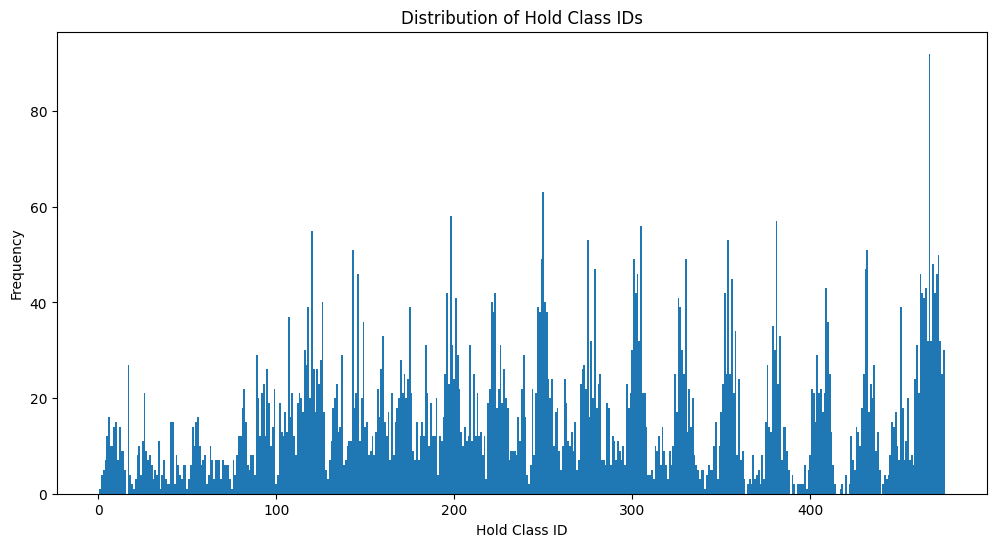

In [ ]:
# import matplotlib.pyplot as plt
# from collections import Counter

# # Extract all labels from the sequence dataset
# def extract_labels(sequence_dataset):
#     labels = []
#     for _, label in sequence_dataset:
#         labels.append(label.item())  # Ensure label is a standard Python integer
#     return labels

# # Extract labels from the sequence train dataset
# train_labels = extract_labels(sequence_train_dataset)

# # Count the occurrences of each hold class ID
# label_counts = Counter(train_labels)

# # Print the frequencies of each hold class ID in order of class ID
# print("Frequencies of each hold class ID (sorted by class ID):")
# for class_id, frequency in sorted(label_counts.items()):
#     print(f"Hold Class ID: {class_id}, Frequency: {frequency}")

# # Plot the distribution of hold class IDs
# plt.figure(figsize=(12, 6))
# plt.bar(label_counts.keys(), label_counts.values(), width=1.0, align='center')
# plt.xlabel('Hold Class ID')
# plt.ylabel('Frequency')
# plt.title('Distribution of Hold Class IDs')
# plt.show()


### Generate RNN Climb ###

Climb Name: Salah
Actual Hold: 1097 Predicted Hold: 1460, Actual Hold Class: 42, Predicted Hold Class: 4
Actual Hold: 1099 Predicted Hold: 1185, Actual Hold Class: 44, Predicted Hold Class: 174
Actual Hold: 1150 Predicted Hold: 1157, Actual Hold Class: 121, Predicted Hold Class: 137
Actual Hold: 1166 Predicted Hold: 1208, Actual Hold Class: 146, Predicted Hold Class: 215
Actual Hold: 1168 Predicted Hold: 1255, Actual Hold Class: 148, Predicted Hold Class: 280
Actual Hold: 1183 Predicted Hold: 1257, Actual Hold Class: 172, Predicted Hold Class: 282
Actual Hold: 1200 Predicted Hold: 1342, Actual Hold Class: 198, Predicted Hold Class: 412
Actual Hold: 1219 Predicted Hold: 1393, Actual Hold Class: 226, Predicted Hold Class: 473
Actual Hold: 1234 Predicted Hold: 1341, Actual Hold Class: 250, Predicted Hold Class: 411
Actual Hold: 1251 Predicted Hold: 1393, Actual Hold Class: 276, Predicted Hold Class: 473
Actual Hold: 1269 Predicted Hold: 1393, Actual Hold Class: 303, Predicted Hold Class: 

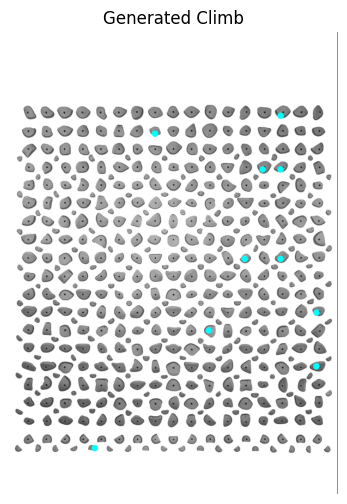

In [ ]:
import torch.nn.functional as F
import random

# def generate_climb(model, starting_hold_id, starting_val, num_holds):
#     model.eval()
    
#     # Initialize the starting tuple and convert to tensor
#     starting_class_id = id_to_class_id(starting_hold_id)
#     current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val)], dtype=torch.float).unsqueeze(0).to(device)

#     generated_hold_ids = [starting_hold_id]
#     generated_vals = [starting_val]

#     # Initialize hidden states
#     h0, c0 = None, None
    
#     with torch.no_grad():
#         for _ in range(num_holds - 1):
#             lengths = torch.tensor([current_tuple.size(1)], dtype=torch.int64).to(device)

#             hold_val_class_logits, h0, c0 = model(current_tuple, lengths, h0, c0)
            
#             # Apply softmax to convert logits to probabilities
#             hold_val_class_prob = F.softmax(hold_val_class_logits, dim=1)
            

#             # The rest of your code to process the sampled hold_val_class_id
#             hold_val_class_prob_cpu = hold_val_class_prob.squeeze().cpu().numpy()
#             plt.figure(figsize=(10, 6))
#             plt.bar(range(len(hold_val_class_prob_cpu)), hold_val_class_prob_cpu)
#             plt.xlabel('Hold Value Class ID')
#             plt.ylabel('Probability')
#             plt.title(f'Hold Value Class Probabilities at Step {_ + 1}')
#             plt.show()
#             hold_val_class_id = torch.multinomial(hold_val_class_prob, 1).item()
#             # hold_val_class_id = torch.argmax(hold_val_class_prob, dim=1).item()
#             # hold_val_top_indices = torch.topk(hold_val_class_prob, k=5, dim=1)[1].squeeze().tolist()
#             # hold_val_class_id = random.choice(hold_val_top_indices)
#             hold_class_id, val_class = hold_val_class_id_to_ids(hold_val_class_id)
#             generated_hold_ids.append(class_id_to_id(hold_class_id))
#             generated_vals.append(val_class)

#             # Prepare the next input
#             next_tuple = hold_to_tuple(hold_class_id, val_class)
#             next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
#             # Concatenate next_tensor along the sequence dimension (dim=1)
#             current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
#     return generated_hold_ids, generated_vals

def generate_climb_from_sequence( initial_holds, initial_vals, num_holds):
    model.eval()
    
    generated_hold_ids = initial_holds.copy()
    generated_vals = initial_vals.copy()
    # Convert initial holds and values to the corresponding tuples and tensors
    initial_tuples = [hold_to_tuple(id_to_index2(hold_id), val) for hold_id, val in zip(initial_holds, initial_vals)]
    current_sequence = torch.tensor(initial_tuples, dtype=torch.float).unsqueeze(0).to(device)

    # Initialize hidden states
    h0, c0 = None, None
    
    with torch.no_grad():
        for _ in range(num_holds - len(initial_holds)):
            lengths = torch.tensor([current_sequence.size(1)], dtype=torch.int64).to(device)

            hold_class_logits, h0, c0 = model(current_sequence, lengths, h0, c0)
            
            # Apply softmax to convert logits to probabilities
            hold_class_prob = F.softmax(hold_class_logits, dim=1)

            # The rest of your code to process the sampled hold_class_id
            hold_class_prob_cpu = hold_class_prob.squeeze().cpu().numpy()
            # plt.figure(figsize=(10, 6))
            # plt.bar(range(len(hold_class_prob_cpu)), hold_class_prob_cpu)
            # plt.xlabel('Hold Value Class ID')
            # plt.ylabel('Probability')
            # plt.title(f'Hold Value Class Probabilities at Step {len(generated_hold_ids)}')
            # plt.show()
            
            # Sample the next hold_val_class_id from the probability distribution
            hold_class_id = torch.multinomial(hold_class_prob, 1).item()
            val_class = 3
            
            generated_hold_ids.append(index2_to_id(hold_class_id))
            generated_vals.append(val_class)
            # Prepare the next input
            next_tuple = hold_to_tuple(hold_class_id, val_class)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_sequence = torch.cat((current_sequence, next_tensor), dim=1)

    generated_hold_class_ids = [id_to_class_id(hold_id) for hold_id in initial_holds]
    return generated_hold_ids, generated_vals, generated_hold_class_ids

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        id_2-=2
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

# hold_ids, vals = generate_climb(model, 1081, 3, 12)

# initial_holds = [1081,1077]
# initial_vals = [3,3]
# hold_ids, vals = generate_climb_from_sequence(model, initial_holds, initial_vals, 12)
# climb_to_image(hold_ids, vals)

def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        # frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
        
        # Convert the frame to IDs
        ids_list_1, ids_list_2 = frame_to_ids(random_frame)

        # Initialize lists to store predictions
        predicted_hold_ids = []
        predicted_vals = []
        
        # Iterate through each ID and predict the next hold
        initial_holds = ids_list_1[:1] 
        initial_vals = ids_list_2[:1]  

        for i in range(2, len(ids_list_1)):
            hold_ids, vals, hold_class_ids = generate_climb_from_sequence(initial_holds, initial_vals, len(initial_holds) + 1)
            predicted_hold_ids.append(hold_ids[-1])
            predicted_vals.append(vals[-1])
            print(f"Actual Hold: {ids_list_1[i]} Predicted Hold: {hold_ids[-1]}, Actual Hold Class: {id_to_index2(ids_list_1[i])}, Predicted Hold Class: {id_to_index2(hold_ids[-1])}")
            initial_holds.append(ids_list_1[i])
            initial_vals.append(ids_list_2[i])

        # Calculate accuracy
        correct_predictions = sum(1 for i in range(2, len(ids_list_1)) if ids_list_1[i] == predicted_hold_ids[i-2])
        accuracy = correct_predictions / (len(ids_list_1) - 2)
        print(f"Prediction Accuracy: {accuracy:.2f}")

        # Create the image for the predicted holds
        climb_to_image(predicted_hold_ids, predicted_vals)
    else:
        print("The DataFrame is empty.")

# Example usage:
# Assuming you have a DataFrame `filtered_df` and a trained model `model`
create_random_climb_image(filtered_df)


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
